<a href="https://colab.research.google.com/github/kimayeon-hub/DeepLearning1/blob/main/Week5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chat GPT를 활용하는 딥러닝 집 가격 (House Prices) 예측

## 케글의 House Prices - Advanced Regression Techniques에 참가
- 데이터는 `딥러닝1 > Week5-3`에 저장
- 최종적으로는 **집 가격을 예측**하는 문제임
- 사용할 파일
  - sample_submission.csv
  - test.csv
  - train.csv

## Chat GPT를 사용해 데이터를 읽어오도록 하기
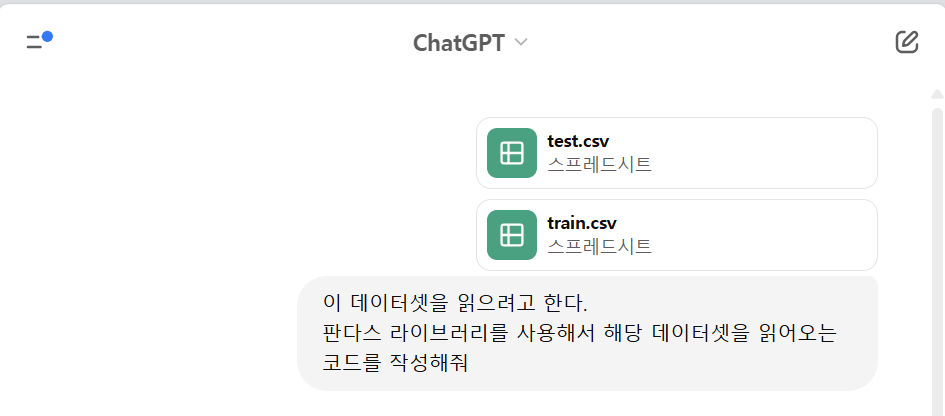

In [3]:
import pandas as pd

# 파일 경로
train_path = './train.csv'
test_path = './test.csv'

# 데이터 읽기
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

## 파일 형식 살펴보기
- train.csv
  - 예측해야 되는 값: 제일 마지막 컬럼인 `SalePrice`
  - NAN 값이 많은 컬럼이 꽤나 있음: `PoolQc`, `Fence`, `MiscFeature`

In [4]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### 컬럼별로 NaN의 비율 확인하기
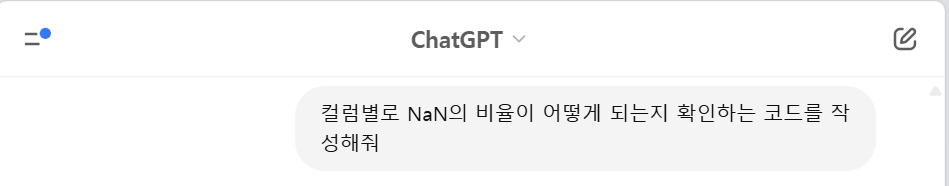

In [5]:
# NaN 비율 계산 함수
def check_nan_ratio(df):
    nan_ratio = df.isna().mean() * 100  # 비율을 퍼센트로 계산
    return nan_ratio.sort_values(ascending=False)

# Train 데이터셋 NaN 비율
print("Train 데이터셋 결측치 비율:")
print(check_nan_ratio(train_df))

# Test 데이터셋 NaN 비율
print("\nTest 데이터셋 결측치 비율:")
print(check_nan_ratio(test_df))

Train 데이터셋 결측치 비율:
PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
MasVnrType       59.726027
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64

Test 데이터셋 결측치 비율:
PoolQC           99.794380
MiscFeature      96.504455
Alley            92.666210
Fence            80.123372
MasVnrType       61.274846
                   ...    
EnclosedPorch     0.000000
MiscVal           0.000000
MoSold            0.000000
YrSold            0.000000
SaleCondition     0.000000
Length: 80, dtype: float64


### NaN 비율이 높은 컬럼 삭제하기
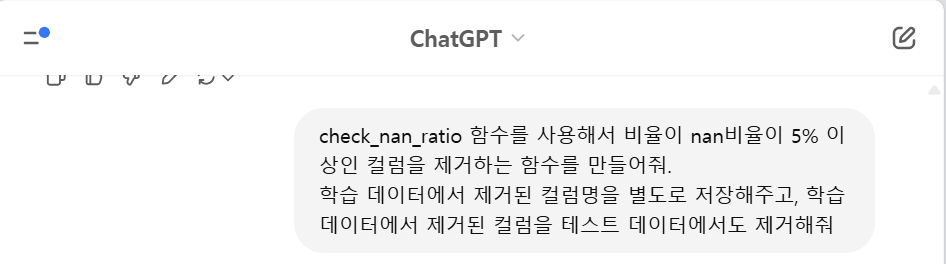

In [76]:
# NaN 비율 확인 함수
def check_nan_ratio(df):
    return df.isna().mean() * 100

# 결측치 비율이 5% 이상인 컬럼 제거 함수
def drop_high_nan_columns(train_df, test_df, threshold=5.0):
    # 1. 학습 데이터에서 결측치 비율 계산
    train_nan_ratio = check_nan_ratio(train_df)

    # 2. 5% 이상인 컬럼 추출
    cols_to_drop = train_nan_ratio[train_nan_ratio >= threshold].index.tolist()

    # 3. 학습 데이터에서 제거
    train_df_cleaned = train_df.drop(columns=cols_to_drop)

    # 4. 테스트 데이터에서도 동일한 컬럼 제거
    test_df_cleaned = test_df.drop(columns=cols_to_drop, errors='ignore')

    # 5. 제거된 컬럼명 반환
    return train_df_cleaned, test_df_cleaned, cols_to_drop

# 사용 예시
train_df_cleaned, test_df_cleaned, removed_columns = drop_high_nan_columns(train_df, test_df)

print(f"제거된 컬럼명 ({len(removed_columns)}개): {removed_columns}")

제거된 컬럼명 (12개): ['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


### train 데이터에 NaN 값이 아직 남아 있다면, 그 행 지우기
- test 데이터셋에서 row는 지우면 안 됨


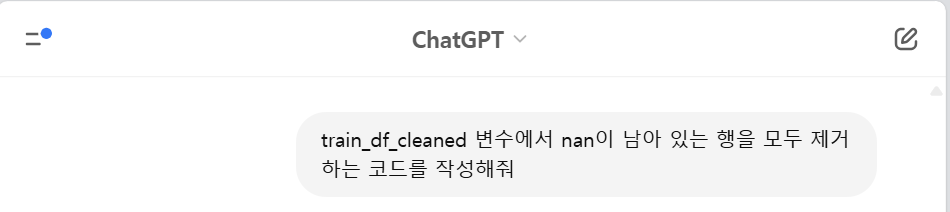

In [7]:
# NaN이 포함된 행 제거
train_df_cleaned = train_df_cleaned.dropna()

# 결과 확인
print(f"NaN 제거 후 학습 데이터 shape: {train_df_cleaned.shape}")

NaN 제거 후 학습 데이터 shape: (1412, 69)


### test 데이터에 NaN이 있는지 확인하기
- test 데이터에 NaN이 있으면 안 됨


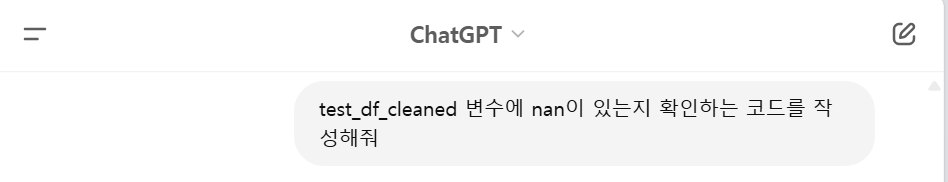

In [8]:
# NaN이 있는지 여부 확인
has_nan = test_df_cleaned.isna().any().any()

if has_nan:
    print("test_df_cleaned에는 NaN이 존재합니다.")
else:
    print("test_df_cleaned에는 NaN이 없습니다.")

test_df_cleaned에는 NaN이 존재합니다.


### test 데이터에 NaN 값이 있는 컬럼을 train, test 데이터 모두에서 제거하기
- test 데이터에는 NaN 값이 있으면 안 됨
  - 예측할 때 사용해야 하는 값이 NaN이면 예측이 안 됨
  - NaN 값을 예측해서 그 데이터도 사용할 수 있지만,
  - 그건 복잡하므로 여기서는 해당 컬럼을 제거할 것


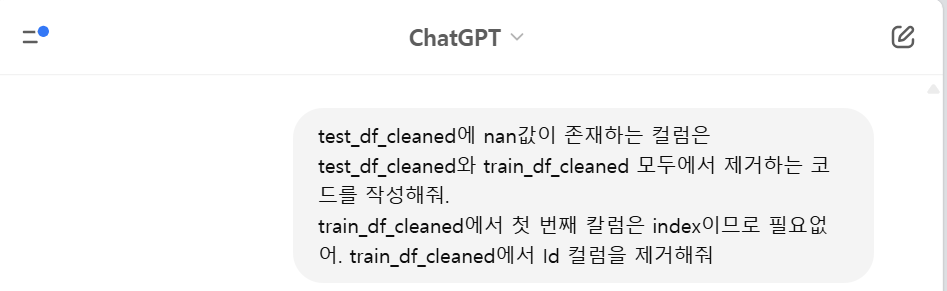


In [9]:
# 1. test_df_cleaned에서 NaN이 존재하는 컬럼 찾기
nan_cols_in_test = test_df_cleaned.columns[test_df_cleaned.isna().any()].tolist()

# 2. 해당 컬럼들을 두 데이터셋에서 제거
train_df_cleaned = train_df_cleaned.drop(columns=nan_cols_in_test, errors='ignore')
test_df_cleaned = test_df_cleaned.drop(columns=nan_cols_in_test, errors='ignore')

# 3. train_df_cleaned에서 'Id' 컬럼 제거
if 'Id' in train_df_cleaned.columns:
    train_df_cleaned = train_df_cleaned.drop(columns=['Id'])

# 결과 출력
print(f"test_df_cleaned에서 NaN이 있어 제거된 컬럼들: {nan_cols_in_test}")
print(f"최종 train_df_cleaned shape: {train_df_cleaned.shape}")
print(f"최종 test_df_cleaned shape: {test_df_cleaned.shape}")

test_df_cleaned에서 NaN이 있어 제거된 컬럼들: ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea', 'SaleType']
최종 train_df_cleaned shape: (1412, 47)
최종 test_df_cleaned shape: (1459, 47)


In [10]:
test_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1459 non-null   int64 
 1   MSSubClass     1459 non-null   int64 
 2   LotArea        1459 non-null   int64 
 3   Street         1459 non-null   object
 4   LotShape       1459 non-null   object
 5   LandContour    1459 non-null   object
 6   LotConfig      1459 non-null   object
 7   LandSlope      1459 non-null   object
 8   Neighborhood   1459 non-null   object
 9   Condition1     1459 non-null   object
 10  Condition2     1459 non-null   object
 11  BldgType       1459 non-null   object
 12  HouseStyle     1459 non-null   object
 13  OverallQual    1459 non-null   int64 
 14  OverallCond    1459 non-null   int64 
 15  YearBuilt      1459 non-null   int64 
 16  YearRemodAdd   1459 non-null   int64 
 17  RoofStyle      1459 non-null   object
 18  RoofMatl       1459 non-null

In [11]:
train_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1412 entries, 0 to 1459
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1412 non-null   int64 
 1   LotArea        1412 non-null   int64 
 2   Street         1412 non-null   object
 3   LotShape       1412 non-null   object
 4   LandContour    1412 non-null   object
 5   LotConfig      1412 non-null   object
 6   LandSlope      1412 non-null   object
 7   Neighborhood   1412 non-null   object
 8   Condition1     1412 non-null   object
 9   Condition2     1412 non-null   object
 10  BldgType       1412 non-null   object
 11  HouseStyle     1412 non-null   object
 12  OverallQual    1412 non-null   int64 
 13  OverallCond    1412 non-null   int64 
 14  YearBuilt      1412 non-null   int64 
 15  YearRemodAdd   1412 non-null   int64 
 16  RoofStyle      1412 non-null   object
 17  RoofMatl       1412 non-null   object
 18  ExterQual      1412 non-null   ob

### train 데이터의 컬럼 중에서 모든 값이 동일한 컬럼 삭제하기
- 모든 값이 동일한 컬럼은 필요 없는 컬럼임
- 데이터가 작을수록 좋으므로 해당 행은 삭제하기


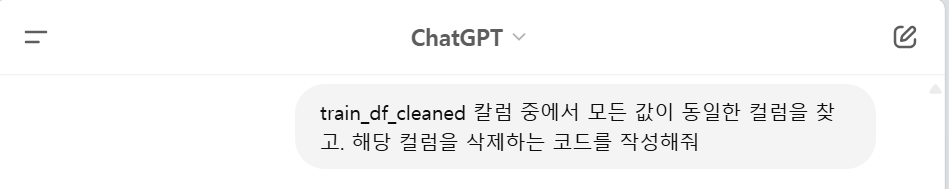

In [12]:
# 1. 모든 값이 동일한 컬럼 찾기
constant_cols = [col for col in train_df_cleaned.columns if train_df_cleaned[col].nunique() == 1]

# 2. 해당 컬럼 제거
train_df_cleaned = train_df_cleaned.drop(columns=constant_cols)

# 3. 결과 출력
print(f"모든 값이 동일해서 제거된 컬럼들 ({len(constant_cols)}개): {constant_cols}")

모든 값이 동일해서 제거된 컬럼들 (0개): []


## 어떤 모델을 사용할 것인지 결정: 다층 신경망
- 다층신경망을 사용하려면 **모든 데이터를 수치화**해서 집어 넣어야 함

### test 데이터 수치화하기

In [13]:
import numpy as np
import pandas as pd

# 숫자가 아닌 컬럼 찾기
non_numeric_cols = train_df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric_cols

['Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'PavedDrive',
 'SaleCondition']

In [34]:
import pandas as pd
import numpy as np

# 1. 숫자가 아닌 컬럼 찾기
non_numeric_cols = train_df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
print("숫자가 아닌 컬럼:", non_numeric_cols)

# 2. 숫자가 아닌 컬럼에 대해서 원 핫 인코딩을 했을 때 전체 컬럼의 수가 어떻게 될지 계산
total_columns = 0
for col in train_df_cleaned.columns:
  if col in non_numeric_cols:
    # 해당 컬럼의 고유값 개수를 더한다.
    total_columns += train_df_cleaned[col].nunique()
  else:
    # 숫자 컬럼은 1개로 계산한다.
    total_columns += 1

print("원 핫 인코딩 후 예상 컬럼 수:", total_columns)

# 3. 해당 숫자를 사용해서 빈 넘파이 배열을 만들기
num_rows = train_df_cleaned.shape[0]
train_array = np.zeros((num_rows, total_columns), dtype=np.float32)
print("빈 넘파이 배열 생성 완료. 배열 형태:", train_array.shape)

# 4. train_df_encoded의 모든 컬럼에 대해서 반복하여 변환
current_col = 0
for col in train_df_cleaned.columns:
  if col in non_numeric_cols:
    # 원 핫 인코딩 수행
    unique_values = train_df_cleaned[col].unique()
    one_hot_encoded = pd.get_dummies(train_df_cleaned[col], prefix=col)
    # 배열에 삽입
    num_one_hot_cols = one_hot_encoded.shape[1]
    train_array[:, current_col:current_col + num_one_hot_cols] = one_hot_encoded.to_numpy()
    current_col += num_one_hot_cols
  else:
    # 숫자 컬럼 그대로 삽입
    train_array[:, current_col] = train_df_cleaned[col].to_numpy()
    current_col += 1

print("데이터 변환 완료. 최종 배열 형태:", train_array.shape)
# print("변환된 데이터 일부:")
# print(train_array[:5])

숫자가 아닌 컬럼: ['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'PavedDrive', 'SaleCondition']
원 핫 인코딩 후 예상 컬럼 수: 152
빈 넘파이 배열 생성 완료. 배열 형태: (1412, 152)
데이터 변환 완료. 최종 배열 형태: (1412, 152)


In [32]:
# 마지막 컬럼인 SalePrice(집 값)가 잘 들어가 있는지 확인
train_array[:, -1]

array([208500., 181500., 223500., ..., 266500., 142125., 147500.],
      dtype=float32)

In [35]:
train_array.shape

(1412, 152)

### train 데이터 수치화하기
- test 데이터와 동일하게 수치화하면 됨
- test 데이터에서는 index(컬럼이름: Id)를 제거하지 않음.
  - Id 컬럼을 별도로 저장하고,
  - test_array에는 저장하지 않기

In [37]:
import pandas as pd
import numpy as np

# 0. Id 컬럼을 별도로 저장하고 제거
if 'Id' in test_df_cleaned.columns:
  id_column = test_df_cleaned['Id']
  test_df_cleaned = test_df_cleaned.drop(columns=['Id'])
  print("Id 컬럼 제거 완료. 저장된 Id 컬럼 형태:", id_column.shape)

# 1. 숫자가 아닌 컬럼을 찾기
non_numeric_cols = test_df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
print("숫자가 아닌 컬럼:", non_numeric_cols)

# 2. 숫자가 아닌 컬럼에 대해서 원 핫 인코딩을 했을 때 전체 칼럼의 수가 어떻게 될지 계산
total_columns = 0
for col in test_df_cleaned.columns:
  if col in non_numeric_cols:
    # 해당 컬럼의 고유값 개수를 더하기
    total_columns += test_df_cleaned[col].nunique()
  else:
    # 숫자 컬럼은 1개로 계산
    total_columns += 1

print("원 핫 인코딩 후 예상 컬럼 수:", total_columns)

# 3. 해당 숫자를 사용해서 빈 넘파이 배열을 만들기
num_rows = test_df_cleaned.shape[0]
test_array = np.zeros((num_rows, total_columns), dtype=np.float32)
print("빈 넘파이 배열 생성 완료. 배열 형태:", test_array.shape)

# 4. test_df_encoded의 모든 컬럼에 대해서 반복하여 변환
current_col = 0
for col in test_df_cleaned.columns:
  if col in non_numeric_cols:
    # 원 핫 인코딩 수행
    unique_values = test_df_cleaned[col].unique()
    one_hot_encoded = pd.get_dummies(test_df_cleaned[col], prefix=col)
    # 배열에 삽입
    num_one_hot_cols = one_hot_encoded.shape[1]
    test_array[:, current_col:current_col + num_one_hot_cols] = one_hot_encoded.to_numpy()
    current_col += num_one_hot_cols
  else:
    # 숫자 컬럼 그대로 삽입
    test_array[:, current_col] = test_df_cleaned[col].to_numpy()
    current_col += 1

print("데이터 변환 완료. 최종 배열 형태:", test_array.shape)
# print("변환된 데이터 일부:")
# print(test_array[:5])

숫자가 아닌 컬럼: ['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'PavedDrive', 'SaleCondition']
원 핫 인코딩 후 예상 컬럼 수: 143
빈 넘파이 배열 생성 완료. 배열 형태: (1459, 143)
데이터 변환 완료. 최종 배열 형태: (1459, 143)


### train, test 수치화에서 잘못된 점 수정하기
- train_array와 test_array의 컬럼 수가 다름
  - train_array를 원 핫 인코딩 한 방법과 똑같이 test 데이터에 대해서도 원 핫 인코딩을 해야 함
- test 데이터에는 SalePrice 컬럼이 없음
  - 해당 컬럼명은 테스트 데이터에 대해서는 적용할 필요가 없음

In [67]:
import pandas as pd
import numpy as np

# 0. test 데이터에서 Id 컬럼 제거 및 저장
if 'Id' in test_df_cleaned.columns:
  id_column = test_df_cleaned['Id'].to_numpy()
  test_df_cleaned = test_df_cleaned.drop(columns=['Id'])
  print("Id 컬럼 제거 완료. 저장된 Id 컬럼 형태:", id_column.shape)

# 1. train 데이터에서 숫자가 아닌 컬럼 찾기 (SalePrice 제외)
non_numeric_cols = train_df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
if 'SalePrice' in non_numeric_cols:
  non_numeric_cols.remove('SalePrice')
print("숫자가 아닌 컬럼 (SalePrice 제외):", non_numeric_cols)

# 2. train 데이터에서 원 핫 인코딩 후 컬럼 수 계산
total_columns = 0
encoding_info = {}  # 각 컬럼별 인코디 정보를 저장할 딕셔너리

for col in train_df_cleaned.columns:
  if col == 'SalePrice':
    total_columns += 1  # SalePrice는 숫자형으로 그대로 추가
  elif col in non_numeric_cols:
    unique_values = train_df_cleaned[col].unique()
    encoding_info[col] = unique_values  # 원 핫 인코딩 값 기억
    total_columns += len(unique_values)
  else:
    total_columns += 1

print("원 핫 인코딩 후 예상 컬럼 수:", total_columns)

# 3. 빈 넘파이 배열 생성
num_rows_train = train_df_cleaned.shape[0]
num_rows_test = train_df_cleaned.shape[0]
train_array = np.zeros((num_rows_train, total_columns), dtype=np.float32)
test_array = np.zeros((num_rows_test, total_columns), dtype=np.float32)
print("빈 넘파이 생성 완료. 학습 배열 형태:", train_array.shape, "테스트 배열 형태:", test_array.shape)

# 4. 학습 데이터와 테스트 데이터를 같은 기준으로 변환
def one_hot_encode_value(value, unique_values):
  # 원 핫 인코딩 벡터를 반환
  one_hot_vector = np.zeros(len(unique_values), dtype=np.float32)
  if value in unique_values:
    index = np.where(unique_values == value)[0][0]
    one_hot_vector[index] = 1.0
  return one_hot_vector

# 변환 함수
def transform_dataframe(df, encoding_info, is_train=True):
  current_col = 0
  num_cols = total_columns if is_train else total_columns - 1
  transformed_array = np.zeros((df.shape[0], num_cols), dtype=np.float32)

  for col in train_df_cleaned.columns:
    if col == 'SalePrice' and not is_train:
      continue  # 테스트 데이터에 SalePrice는 없음

    if col in non_numeric_cols:
      unique_values = encoding_info[col]
      for i, value in enumerate(df[col]):
        one_hot_vector = one_hot_encode_value(value, unique_values)
        transformed_array[i, current_col:current_col + len(unique_values)] = one_hot_vector
      current_col += len(unique_values)
    else:
      transformed_array[:, current_col] = df[col].to_numpy()
      current_col += 1

  return transformed_array

# 학습 데이터 변환
train_array = transform_dataframe(train_df_cleaned, encoding_info, is_train=True)
print("학습 데이터 변환 완료. 배열 형태:", train_array.shape)

# 테스트 데이터 변환
test_array = transform_dataframe(test_df_cleaned, encoding_info, is_train=False)
print("테스트 데이터 변환 완료. 배열 형태:", test_array.shape)

숫자가 아닌 컬럼 (SalePrice 제외): ['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'PavedDrive', 'SaleCondition']
원 핫 인코딩 후 예상 컬럼 수: 152
빈 넘파이 생성 완료. 학습 배열 형태: (1412, 152) 테스트 배열 형태: (1412, 152)
학습 데이터 변환 완료. 배열 형태: (1412, 152)
테스트 데이터 변환 완료. 배열 형태: (1459, 151)


### train_array의 마지막 컬럼(SalePrice)를 train_y로 분리


In [68]:
train_y = train_array[:, -1]
train_x = train_array[:, :-1] # 마지막 컬럼을 제외한 나머지
test_x = test_array

### 정규화하기
- 어떤 컬럼의 값은 너무 작고, 어떤 컬럼의 값은 너무 큼
- 0 ~ 1 사이로 정규화할 필요가 있음
- min, max 값을 저장하는 이유
> y 값은 나중에 복원을 해야 하므로 min, max값을 저장해 놓아야 함

In [69]:
import numpy as np

# train_x의 최대값과 최소값 계산
train_x_min = np.min(train_x, axis=0)
train_x_max = np.max(train_x, axis=0)

# train_y의 최대값과 최소값 계산
train_y_min = np.min(train_y)
train_y_max = np.max(train_y)

# 정규화 함수
def normalize(data, min_val, max_val):
  return (data - min_val) / (max_val - min_val)

# 정규화
train_x = normalize(train_x, train_x_min, train_x_max)
train_y = (train_y - train_y_min) / (train_y_max - train_y_min)

test_x = normalize(test_x, train_x_min, train_x_max)

In [70]:
train_x

array([[0.23529412, 0.0334198 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03879502, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.23529412, 0.04650728, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.29411766, 0.03618687, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03934189, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04037019, 1.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

## 딥러닝 모델 만들기
- MLP를 사용해서 train_x, train_y 데이터를 학습하려고 함
- fit을 할 때, validation을 나눌 것임

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0206 - mae: 0.1083 - val_loss: 0.0058 - val_mae: 0.0522
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0480 - val_loss: 0.0052 - val_mae: 0.0481
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mae: 0.0366 - val_loss: 0.0047 - val_mae: 0.0427
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 0.0047 - val_mae: 0.0420
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0050 - val_mae: 0.0444
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0277 - val_loss: 0.0049 - val_mae: 0.0419
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5736e-04 - mae: 0.0231 - val_loss: 0.0049 - val_mae: 0.0422
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7027e-04 - mae: 0.0214 - val_loss: 0.0052 - val_mae: 0.0419
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4848

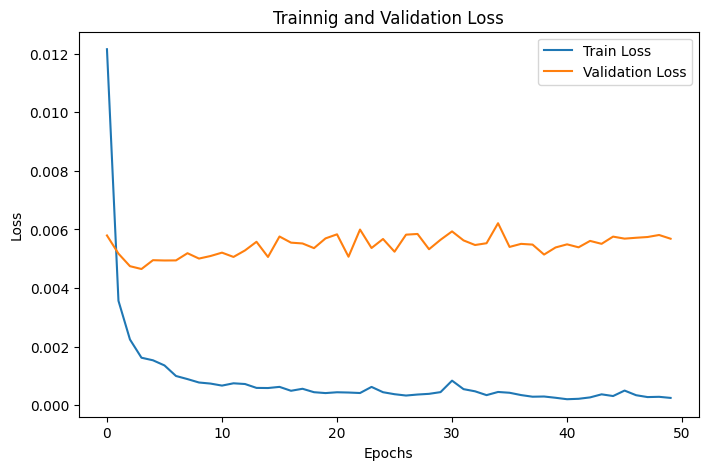

In [71]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# MLP 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_x.shape[1],)), # 입력층
    Dense(64, activation='relu'), # 은닉층
    Dense(1, activation='linear') # 출력층 (회귀 무네라면 'linear', 분류라면 'sigmoid' 또는 'softmax)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 모델 학습 (검증 데이터 비율: 20%)
history = model.fit(train_x, train_y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 모델 평가
loss, mae = model.evaluate(train_x, train_y)
print(f"\n훈련 손실: {loss:.4f}, 훈련 MAE: {mae:.4f}")

# 학습 및 검증 손실 시각화
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Trainnig and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

- loss 값이 계속 떨어지고 있음
  - 학습이 어느 정도 잘 되었다고 생각 할 수 있음
- validation loss 값은 어느 정도 유지되고 있음
> 어느 정도 학습이 되었다고 생각할 수 있음

## test 데이터를 가지고 예측하기
- test_x 데이터를 사용해서 예측
- 예측된 값은 기억해 놓았던 min, max 정보를 사용해서 다시 원래 스케일로 바꿔주기

In [72]:
# 테스트 데이터 예측
predictions = model.predict(test_x)
print("\n테스트 데이터 예측 완료.")

# 예측된 값을 원래 스케일로 변환하는 함수
def inverse_normalize(data, min_val, max_val):
  return data * (max_val - min_val) + min_val

# 예측값을 원래 스케일로 변환
predictions_original = inverse_normalize(predictions, train_y_min, train_y_max)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

테스트 데이터 예측 완료.


In [73]:
predictions_original

array([[134431.31],
       [155604.84],
       [178172.19],
       ...,
       [166712.16],
       [ 98782.36],
       [211437.64]], dtype=float32)

## 예측값을 sample_submission 형태로 바꾸기
- sample_submission.csv 파일을 읽어서 수정
  - test.csv와 sample_submission.csv의 Id 컬럼은 값이 같음
- SalePrice 컬럼의 데이터를 predictions_original로 대체하기
  - `.flatten()`: 2차원으로 되어 있는 것을 1차원으로 만들어주는 것
- 새로운 이름으로 저장하기

In [74]:
import pandas as pd

# sample_submission.csv 파일 읽기
sample_submission = pd.read_csv('sample_submission.csv')

# SalePrice 컬럼의 데이터를 predictions_original로 대체하기
sample_submission['SalePrice'] = predictions_original.flatten()

# 새로운 이름으로 저장
sample_submission.to_csv('output1.csv', index=False)

In [75]:
sample_submission

,Id,SalePrice
0,1461,134431.312500
1,1462,155604.843750
2,1463,178172.187500
3,1464,198050.578125
4,1465,232090.921875
...,...,...
1454,2915,99860.500000
1455,2916,61424.902344
1456,2917,166712.156250
1457,2918,98782.359375
